In [1]:
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import models

In [2]:
TRAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/imgs_cnn/oralens/TRAIN"
TEST_PATH = "/content/drive/MyDrive/Colab Notebooks/imgs_cnn/oralens/TEST"
IMG_SIZE = 128
BATCH_SIZE = 32

# Define transformations (apply the same to both train and test)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize all images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load datasets
train_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=transform)
test_dataset = datasets.ImageFolder(root=TEST_PATH, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print dataset information
print(f"Train Classes: {train_dataset.classes}")
print(f"Train Samples: {len(train_dataset)}")
print(f"Test Samples: {len(test_dataset)}")

Train Classes: ['Caries', 'Gingivitis']
Train Samples: 1486
Test Samples: 408


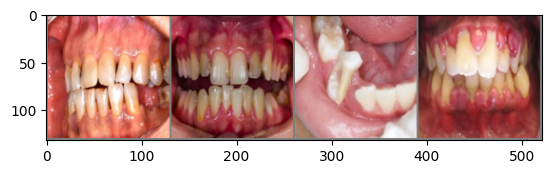

Labels: ['Gingivitis', 'Gingivitis', 'Caries', 'Gingivitis']


In [3]:
import matplotlib.pyplot as plt

# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Unnormalize and plot
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display sample images
imshow(torchvision.utils.make_grid(images[:4]))
print("Labels:", [train_dataset.classes[label] for label in labels[:4]])


In [4]:
# Access an image and label from the dataset
image, label = test_dataset[0]  # Get the first sample

# Check the shape of the image tensor
print(f"Image Tensor Shape: {image.shape}")  # Shape is [C, H, W]
print(f"Label: {label}")  # Class index

Image Tensor Shape: torch.Size([3, 128, 128])
Label: 0


In [5]:
train_dataset.classes

['Caries', 'Gingivitis']

In [6]:
resnet50 = models.resnet50(pretrained=True)

num_classes = len(train_dataset.classes)

resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 113MB/s]


In [7]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)

In [8]:
from tqdm import tqdm

num_epochs = 10  # Adjust based on dataset size

for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"Epoch {epoch + 1}/{num_epochs}")
    for images, labels in tqdm(train_loader):
        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet50(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    print(f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Save the trained model
torch.save(resnet50.state_dict(), "/content/resnet50_oral_disease.pth")
print("Model saved at /content/resnet50_oral_disease.pth")

Epoch 1/10


100%|██████████| 47/47 [10:52<00:00, 13.88s/it]


Loss: 0.3557, Accuracy: 0.8856
Epoch 2/10


100%|██████████| 47/47 [07:07<00:00,  9.10s/it]


Loss: 0.2695, Accuracy: 0.9011
Epoch 3/10


100%|██████████| 47/47 [07:10<00:00,  9.17s/it]


Loss: 0.1739, Accuracy: 0.9455
Epoch 4/10


100%|██████████| 47/47 [07:13<00:00,  9.21s/it]


Loss: 0.1662, Accuracy: 0.9408
Epoch 5/10


100%|██████████| 47/47 [07:02<00:00,  8.98s/it]


Loss: 0.1242, Accuracy: 0.9529
Epoch 6/10


100%|██████████| 47/47 [07:01<00:00,  8.97s/it]


Loss: 0.0987, Accuracy: 0.9677
Epoch 7/10


100%|██████████| 47/47 [07:10<00:00,  9.15s/it]


Loss: 0.0922, Accuracy: 0.9664
Epoch 8/10


100%|██████████| 47/47 [07:12<00:00,  9.20s/it]


Loss: 0.0858, Accuracy: 0.9731
Epoch 9/10


100%|██████████| 47/47 [07:08<00:00,  9.12s/it]


Loss: 0.0871, Accuracy: 0.9711
Epoch 10/10


100%|██████████| 47/47 [06:57<00:00,  8.89s/it]


Loss: 0.0877, Accuracy: 0.9684
Model saved at /content/resnet50_oral_disease.pth


In [9]:
resnet50.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = resnet50(images)

        # Compute loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.1443, Test Accuracy: 0.9510


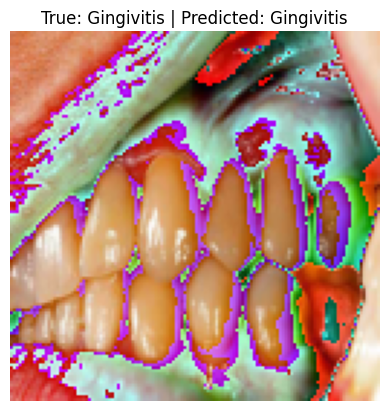

In [11]:
import random
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToPILImage

# Function to visualize and predict a random image
def test_random_image(model, dataset):
    # Pick a random index
    idx = random.randint(0, len(dataset) - 1)

    # Get the image and label
    image, true_label = dataset[idx]

    # Move image to the device and add batch dimension
    image_tensor = image.unsqueeze(0)

    # Get the model's prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_label = torch.max(output, 1)

    # Convert the image tensor to a PIL image for visualization
    pil_image = ToPILImage()(image)

    # Get class names
    class_names = dataset.classes

    # Display the image and prediction
    plt.imshow(pil_image)
    plt.title(f"True: {class_names[true_label]} | Predicted: {class_names[predicted_label.item()]}")
    plt.axis("off")
    plt.show()

# Example usage
test_random_image(resnet50, test_dataset)

In [12]:
save_path = "/content/drive/MyDrive/OralAI.pth"

torch.save(resnet50.state_dict(), save_path)
print(f"Model saved at {save_path}")

Model saved at /content/drive/MyDrive/OralAI.pth
